In [20]:
 # imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import joblib


In [2]:
#  load data
df = pd.read_csv("Tweets.csv")
df.head()


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
#  inspect
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# Fill missing text safely (prevents AttributeError)
df['text'] = df['text'].fillna('').astype(str)


Columns: ['textID', 'text', 'selected_text', 'sentiment']
Missing values:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [4]:
#  create simple numeric features
df['text_length'] = df['text'].str.len()
df['word_count']  = df['text'].str.split().str.len()
df['char_count']  = df['text'].str.replace(' ', '', regex=False).str.len()

df[['text','text_length','word_count','char_count']].head()


,text,text_length,word_count,char_count
0,"I`d have responded, if I were going",36,7,29
1,Sooo SAD I will miss you here in San Diego!!!,46,10,36
2,my boss is bullying me...,25,5,21
3,what interview! leave me alone,31,5,26
4,"Sons of ****, why couldn`t they put them on t...",75,14,61


In [5]:
#  encode target
print("Unique sentiment labels:", df['sentiment'].unique())

# convert to categorical codes
df['sentiment_label'] = df['sentiment'].astype('category').cat.codes
label_mapping = dict(enumerate(df['sentiment'].astype('category').cat.categories))
print("Label mapping (code -> label):", label_mapping)

df['sentiment_label'].value_counts()


Unique sentiment labels: ['neutral' 'negative' 'positive']
Label mapping (code -> label): {0: 'negative', 1: 'neutral', 2: 'positive'}


sentiment_label
1    11118
2     8582
0     7781
Name: count, dtype: int64

In [6]:
#  features and target
feature_cols = ['text_length','word_count','char_count']
X = df[feature_cols]
y = df['sentiment_label']

X.shape, y.shape, X.head()


((27481, 3),
 (27481,),
    text_length  word_count  char_count
 0           36           7          29
 1           46          10          36
 2           25           5          21
 3           31           5          26
 4           75          14          61)

In [7]:
#  split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (21984, 3) Test: (5497, 3)


In [8]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [10]:
#  Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
pd.Series(dt_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

print("Decision Tree Accuracy:", round(dt_acc*100,2), "%")
print("\nDecision Tree classification report:\n", classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 36.35 %

Decision Tree classification report:
               precision    recall  f1-score   support

           0       0.30      0.31      0.30      1556
           1       0.41      0.50      0.45      2224
           2       0.34      0.23      0.28      1717

    accuracy                           0.36      5497
   macro avg       0.35      0.35      0.34      5497
weighted avg       0.36      0.36      0.36      5497



In [11]:
#  Random Forest (baseline)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", round(rf_acc*100,2), "%")
print("\nRandom Forest classification report:\n", classification_report(y_test, y_pred_rf))

# Feature importances
pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=False)


Random Forest Accuracy: 37.09 %

Random Forest classification report:
               precision    recall  f1-score   support

           0       0.31      0.23      0.27      1556
           1       0.41      0.53      0.46      2224
           2       0.34      0.29      0.31      1717

    accuracy                           0.37      5497
   macro avg       0.35      0.35      0.35      5497
weighted avg       0.36      0.37      0.36      5497



text_length    0.413160
char_count     0.393677
word_count     0.193163
dtype: float64

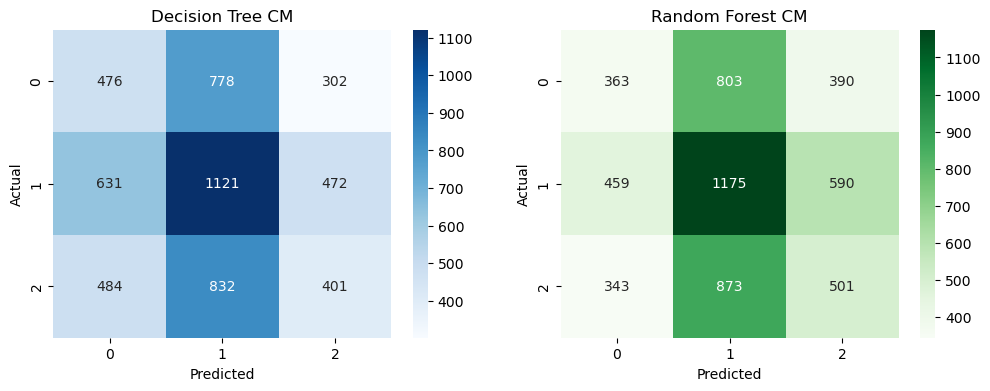

In [12]:
#  confusion matrices
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Decision Tree CM'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('Random Forest CM'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
plt.show()


In [15]:
#  Comparison metrics
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [round(dt_acc*100,2), round(rf_acc*100,2), round(log_acc*100,2)],
    'Precision (macro)': [
        precision_score(y_test, y_pred_dt, average='macro'),
        precision_score(y_test, y_pred_rf, average='macro'),
        precision_score(y_test, y_pred_log, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_test, y_pred_dt, average='macro'),
        recall_score(y_test, y_pred_rf, average='macro'),
        recall_score(y_test, y_pred_log, average='macro')
    ],
    'F1 (macro)': [
        f1_score(y_test, y_pred_dt, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_log, average='macro')
    ]
})
results


,Model,Accuracy,Precision (macro),Recall (macro),F1 (macro)
0,Decision Tree,36.35,0.350311,0.347835,0.344100
1,Random Forest,37.09,0.354003,0.351135,0.347730
2,Logistic Regression,40.00,0.369422,0.340753,0.259356


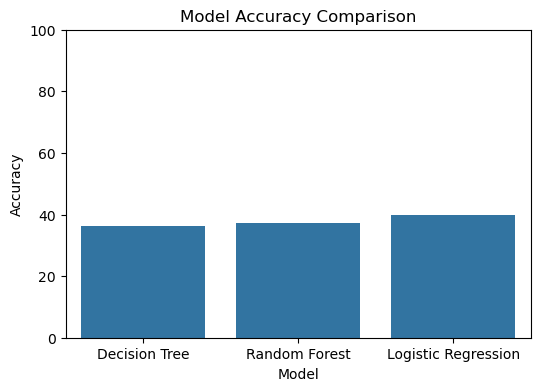

In [16]:
#  plot accuracies
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.ylim(0,100)
plt.title('Model Accuracy Comparison')
plt.show()


In [17]:
#  save best model (example: if RF is best)
best_model = rf_model    # choose which is best based on accuracy
joblib.dump(best_model, 'best_classification_model.joblib')
joblib.dump(scaler, 'scaler.joblib')   # save scaler if Logistic uses it
print("Saved best model and scaler.")


Saved best model and scaler.
